In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import graphgp as gp
import graphgp_cuda as gp_cuda

import matplotlib.pyplot as plt
import time
from tqdm import tqdm

import itertools

rng = jr.key(127)

# Find optimal set of points

In [4]:
def conditional_cov(K, rows, keep_size=False):
    """Compute conditional covariance K11 - K10 K00^(-1) K01"""
    rows = jnp.array(rows)
    remaining = jnp.delete(jnp.arange(len(K)), rows, assume_unique_indices=True)
    K00 = K[jnp.ix_(rows, rows)]
    K01 = K[jnp.ix_(rows, remaining)]
    K10 = K[jnp.ix_(remaining, rows)]
    K11 = K[jnp.ix_(remaining, remaining)]
    K_cond = K11 - K10 @ jnp.linalg.solve(K00, K01)
    
    if keep_size:
        return jnp.zeros_like(K).at[jnp.ix_(remaining, remaining)].set(K_cond)
    return K_cond

def variance_explained(cov_func, fine_point, coarse_points):
    Kfc = gp.compute_cov_matrix(cov_func, fine_point[None], coarse_points)
    Kcc = gp.compute_cov_matrix(cov_func, coarse_points, coarse_points)
    return (Kfc @ jnp.linalg.solve(Kcc, Kfc.T))[0,0]

In [28]:
N = 20
k = 8
combos = jnp.array(list(itertools.combinations(range(N), k)))
print(len(combos))

rng, k1 = jr.split(rng)
points = jr.normal(k1, (N, 2))
target = jnp.array([0.0, 0.0])

125970


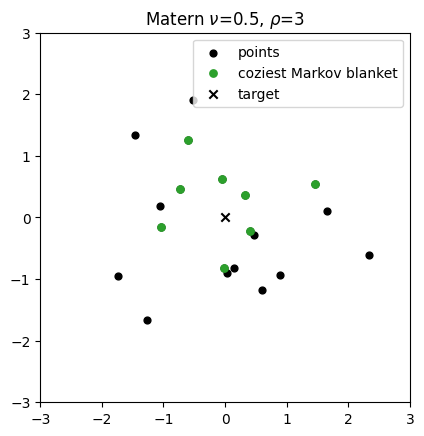

In [165]:
p = 0
cutoff = 3
cov_func = Partial(gp.compute_matern_covariance, p=p, cutoff=cutoff)

score = jax.vmap(Partial(variance_explained, cov_func, target))(points[combos])
best = jnp.argmax(score)

plt.figure(dpi=100)
plt.scatter(*points.T, c='k', label='points', s=24)
plt.scatter(*points[combos[best]].T, c='C2', label='coziest Markov blanket', s=28)
plt.scatter(*target, marker='x', c='k', label='target')
plt.gca().set(aspect='equal', xlim=(-3,3), ylim=(-3,3), title=fr"Matern $\nu$={p+1/2}, $\rho$={cutoff}")
plt.legend()
plt.show()

In [170]:
grid_1d = jnp.linspace(-3, 3, 300)
grid_points = jnp.stack(jnp.meshgrid(grid_1d, grid_1d), axis=-1).reshape(-1, 2)
cond_points = points[combos[best]]
# cond_points = jnp.delete(cond_points, jnp.array([4]), axis=0)
joint_points = jnp.concatenate([jnp.broadcast_to(cond_points, (len(grid_points), *cond_points.shape)), grid_points[:, None, :]], axis=1)

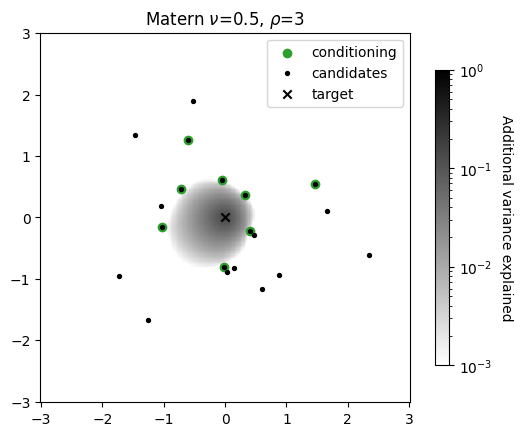

In [174]:
p = 0
cutoff = 3
cov_func = Partial(gp.compute_matern_covariance, p=p, cutoff=cutoff)

base_score = variance_explained(cov_func, target, cond_points)
score = jax.vmap(Partial(variance_explained, cov_func, target))(joint_points) - base_score

fig, ax = plt.subplots(dpi=100)
im = ax.pcolormesh(grid_1d, grid_1d, score.reshape(len(grid_1d), len(grid_1d)), cmap='gray_r', vmin=1e-3, vmax=1, norm='log')
ax.scatter(*cond_points.T, c='C2', label='conditioning') 
ax.scatter(*points.T, c='k', s=8, label='candidates')
ax.scatter(*target.T, c='k', marker='x', label='target')
# ax.scatter(*points[combos[best]][4], marker='o', s=50, edgecolors='C1', facecolors='none', label='next best')
ax.set(aspect='equal', title=fr"Matern $\nu$={p+1/2}, $\rho$={cutoff}")
cbar = plt.colorbar(im, shrink=0.8)
cbar.set_label('Additional variance explained', rotation=270, labelpad=15)
ax.legend()
plt.show()

# Map increase in explained information

In [16]:
rng, k1 = jr.split(rng)
# cond_points = jnp.array([[1.0, 0.2], [0.0, 0.5]])
cond_points = jnp.array([[1.0, 0.2], [0.0, 0.5], [-0.5, -0.5]])
# cond_points = jnp.array([[1.0, 0.2], [0.0, 0.5], [0.5, 0.5], [0.8, 1.0]])
# cond_points = jnp.array([[1.0, 1.0], [-1.0, 0.5], [0.3, 0.8], [-0.5, -0.2]])
target = jnp.array([0.0, 0.0])
grid_1d = jnp.linspace(-4, 4, 300)
grid_points = jnp.stack(jnp.meshgrid(grid_1d, grid_1d), axis=-1).reshape(-1, 2)

joint_points = jnp.concatenate([jnp.broadcast_to(cond_points, (len(grid_points), *cond_points.shape)), grid_points[:, None, :]], axis=1)

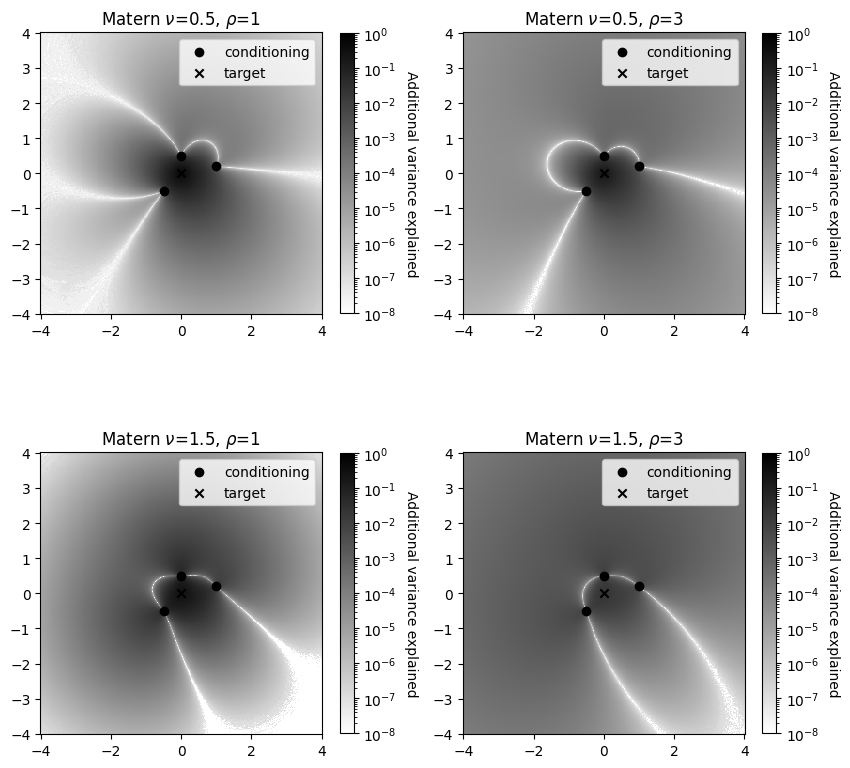

In [17]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10,10), dpi=100)

for i, p in enumerate([0, 1]):
    for j, cutoff in enumerate([1, 3]):
        cov_func = Partial(gp.compute_matern_covariance, p=p, cutoff=cutoff)
        base_score = variance_explained(cov_func, target, cond_points)
        score = jax.vmap(Partial(variance_explained, cov_func, target))(joint_points) - base_score

        im = axes[i,j].pcolormesh(grid_1d, grid_1d, score.reshape(len(grid_1d), len(grid_1d)), cmap='gray_r', vmin=1e-8, vmax=1, norm='log')
        axes[i,j].scatter(*cond_points.T, c='k', label='conditioning') 
        axes[i,j].scatter(*target.T, c='k', marker='x', label='target')
        axes[i,j].set(aspect='equal', title=fr"Matern $\nu$={p+1/2}, $\rho$={cutoff}")
        cbar = plt.colorbar(im, shrink=0.8)
        cbar.set_label('Additional variance explained', rotation=270, labelpad=15)
        axes[i,j].legend()

plt.show()

# Make graph with optimal set of points

In [175]:
def variance_explained(cov_func, fine_point, coarse_points):
    Kfc = gp.compute_cov_matrix(cov_func, fine_point[None], coarse_points)
    Kcc = gp.compute_cov_matrix(cov_func, coarse_points, coarse_points)
    return (Kfc @ jnp.linalg.solve(Kcc, Kfc.T))[0,0]

def find_best_neighbors(cov_func, point, candidates, *, k):
    neighbors = []
    for _ in range(k):
        if len(neighbors) == 0:
            scores = jax.vmap(Partial(variance_explained, cov_func, point))(candidates[None])
        else:
            neighbor_points = candidates[jnp.array(neighbors)]
            neighbor_points = jnp.broadcast_to(neighbor_points, (len(candidates), *neighbor_points.shape))
            combos = jnp.concatenate([neighbor_points, candidates[:, None]], axis=1)
            scores = jax.vmap(Partial(variance_explained, cov_func, point))(combos)
        neighbors.append(jnp.nanargmax(scores))
    return jnp.array(neighbors)

def compute_covariance_kl(K_true, K_model):
    """Compute the KL divergence between two covariance matrices."""
    solved = jnp.linalg.solve(K_model, K_true)
    kl = 1 / 2 * (jnp.trace(solved) - jnp.linalg.slogdet(solved)[1] - len(K_true))
    return kl

In [176]:
rng, k1 = jr.split(rng)

n0 = 100
points = jr.normal(k1, (1000, 2))

graph_64 = gp.build_graph(points, n0=100, k=64, cuda=False)
points = points[graph_64.indices]
graph_64.indices = None

graph_8 = gp.build_graph(points, n0=100, k=8, cuda=True)
graph_16 = gp.build_graph(points, n0=100, k=16, cuda=True)

In [177]:
covariance = gp.prepare_matern_covariance_discrete(p=0, cutoff=3, r_min=1e-5, r_max=10, n_bins=1000)
cov_func = covariance[1]

best_neighbors = jax.vmap(Partial(find_best_neighbors, cov_func, k=8))(points[n0:], points[graph_64.neighbors])
graph_8_opt = gp.Graph(points=points, neighbors=jnp.take_along_axis(graph_64.neighbors, best_neighbors, axis=1), offsets=graph_64.offsets)

In [178]:
covariance = gp.prepare_matern_covariance_discrete(p=0, cutoff=3, r_min=1e-5, r_max=10, n_bins=1000)

# k = 8 naive
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph_8, covariance, cuda=True)))(jnp.zeros(len(points)))
cov_8 = J @ J.T
std_8 = jnp.sqrt(jnp.diag(cov_8))

# k = 16 naive
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph_16, covariance, cuda=True)))(jnp.zeros(len(points)))
cov_16 = J @ J.T
std_16 = jnp.sqrt(jnp.diag(cov_16))

# k = 64 naive
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph_64, covariance, cuda=False)))(jnp.zeros(len(points)))
cov_64 = J @ J.T
std_64 = jnp.sqrt(jnp.diag(cov_64))

# k = 8 optimized
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph_8_opt, covariance, cuda=True)))(jnp.zeros(len(points)))
cov_8_opt = J @ J.T
std_8_opt = jnp.sqrt(jnp.diag(cov_8_opt))

# True
J = jax.jit(jax.jacfwd(Partial(gp.generate_dense, points, covariance)))(jnp.zeros(len(points)))
cov_true = J @ J.T
std_true = jnp.sqrt(jnp.diag(cov_true))

In [179]:
kl_unit = 1#/1000/jnp.log(2)
print('KL divergence from truth (nats for 1000 dof)')
print('k=8 naive:', compute_covariance_kl(cov_true, cov_8) * kl_unit)
print('k=8 optimized:', compute_covariance_kl(cov_true, cov_8_opt) * kl_unit)
print('k=16 naive:', compute_covariance_kl(cov_true, cov_16) * kl_unit)
print('k=64 naive:', compute_covariance_kl(cov_true, cov_64) * kl_unit)

KL divergence from truth (nats for 1000 dof)
k=8 naive: 8.245575
k=8 optimized: 2.5786133
k=16 naive: 1.8022156
k=64 naive: 0.042663574


NameError: name 'std_small' is not defined

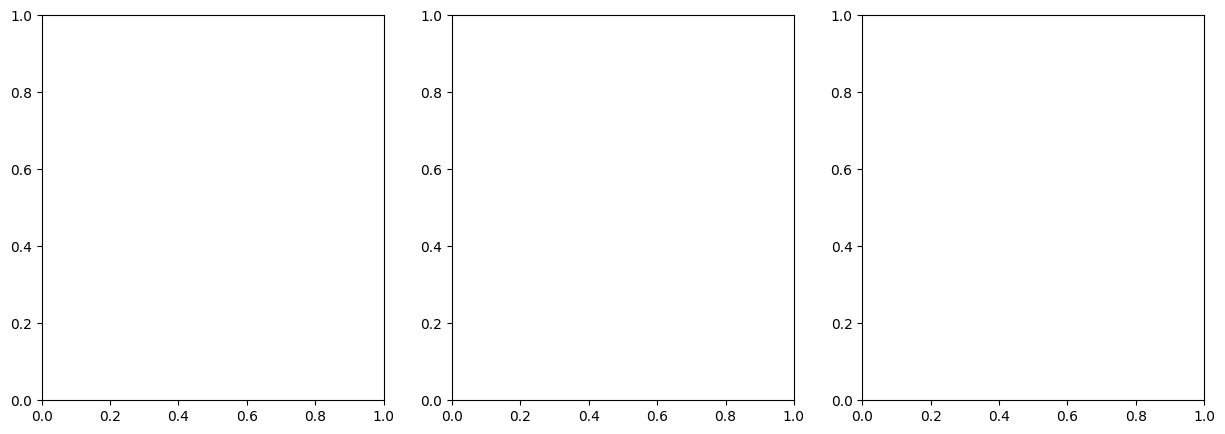

In [180]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))

axes[0].scatter(*points.T, c=std_small - 1, cmap='PiYG', s=2, vmin=-0.01, vmax=0.01)
axes[1].scatter(*points.T, c=std_best - 1, cmap='PiYG', s=2, vmin=-0.01, vmax=0.01)
im = axes[2].scatter(*points.T, c=std_max - 1, cmap='PiYG', s=2, vmin=-0.01, vmax=0.01)

cbar = plt.colorbar(im, ax=axes, shrink=0.7)
cbar.set_label('std - 1', rotation=270, labelpad=15)

for i, ax in enumerate(axes):
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3), title=['k=8 naive', 'k=8 optimized', 'k=64'][i])
plt.show()

In [59]:
true_values = gp.generate_dense(points, covariance, xi)
values = gp.generate_jit(graph, covariance, xi, cuda=True)

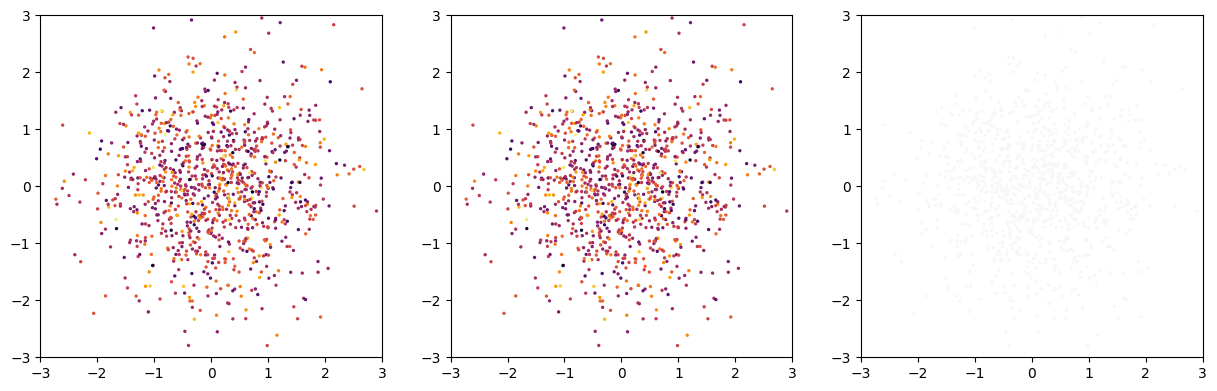

In [60]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
axes[0].scatter(*points.T, c=true_values, cmap='inferno', s=2)
axes[1].scatter(*points.T, c=values, cmap='inferno', s=2)
axes[2].scatter(*points.T, c=true_values-values, cmap='PiYG', s=2, vmin=-0.1, vmax=0.1)

for ax in axes:
    ax.set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.show()

# Inspect graph

In [440]:
rng, k1 = jr.split(rng)

In [441]:
points = jr.normal(k1, (1000, 2))
graph = gp.build_graph(points, n0=100, k=4, cuda=True)
points = points[graph.indices]
graph.indices = None
covariance = gp.prepare_matern_covariance_discrete(p=1, r_min=1e-4, r_max=10, n_bins=1000)

In [457]:
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True)))(jnp.zeros((points.shape[0],)))
cov = J @ J.T
var = jnp.diag(cov)

In [458]:
jnp.flatnonzero(var < 0.95)

Array([160, 240, 270, 278, 353, 367, 373, 397, 420, 441, 488, 505, 506,
       529, 559, 588, 629, 672, 723, 735, 737, 748, 750, 781, 787, 805,
       825, 843, 864, 885, 892, 894, 905, 920, 922, 937, 955, 958, 969],      dtype=int32)

In [473]:
idx = 160
var[idx]

Array(0.9323704, dtype=float32)

In [474]:
graph.neighbors[idx - 100]

Array([ 63, 121, 130,  95], dtype=int32)

In [477]:
graph.neighbors[121-100]

Array([63, 31, 95, 15], dtype=int32)

[None]

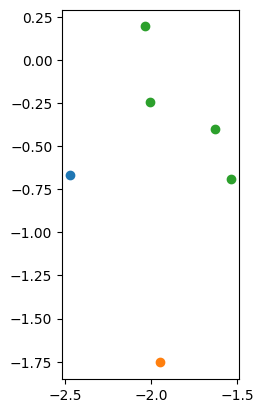

In [483]:
for i in [130, 63, graph.neighbors[130-100]]:
    plt.scatter(*points[i].T)
plt.gca().set(aspect='equal')

In [481]:
cov[graph.neighbors[idx - 100], :][:, graph.neighbors[idx - 100]]

Array([[1.000182  , 0.95421606, 0.24373233, 0.5978451 ],
       [0.95421606, 1.0003774 , 0.20177533, 0.4876039 ],
       [0.24373233, 0.20177533, 0.9996263 , 0.4396452 ],
       [0.5978451 , 0.4876039 , 0.4396452 , 1.0000598 ]], dtype=float32)

In [482]:
gp.covariance.compute_cov_matrix(covariance, points[graph.neighbors[idx - 100]], points[graph.neighbors[idx - 100]])

Array([[1.00001   , 0.95396364, 0.38280845, 0.5978137 ],
       [0.95396364, 1.00001   , 0.32336026, 0.4875949 ],
       [0.38280845, 0.32336026, 1.00001   , 0.47791776],
       [0.5978137 , 0.4875949 , 0.47791776, 1.00001   ]], dtype=float32)

# Unit Circle Case

In [345]:
n_points = 300
theta = jnp.linspace(0, 2*jnp.pi, n_points, endpoint=False)
points = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=1)
neighbors = jnp.stack([jnp.concatenate([jnp.arange(n_points-3), jnp.array([n_points-2])]), 
                       jnp.concatenate([jnp.arange(1, n_points-2), jnp.array([0])])], axis=1)
offsets = tuple(range(2, len(points) + 1))
graph = gp.Graph(points=points, neighbors=neighbors, offsets=offsets)
covariance = gp.prepare_matern_covariance_discrete(p=1, r_min=1e-4, r_max=10, n_bins=1000)

In [346]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, (points.shape[0],))
values = gp.generate_jit(graph, covariance, xi, cuda=True)

[None]

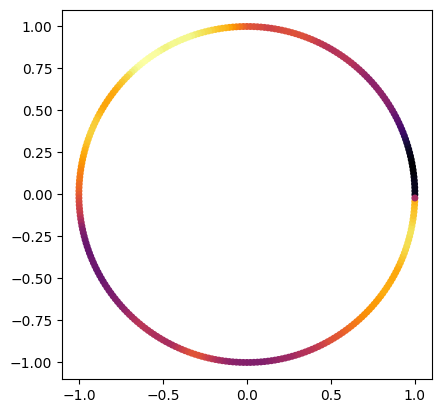

In [347]:
plt.scatter(*points.T, c=values, cmap='inferno', s=16)
plt.gca().set(aspect='equal')

In [348]:
J = jax.jit(jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True)))(xi)
var = jnp.diag(J @ J.T)

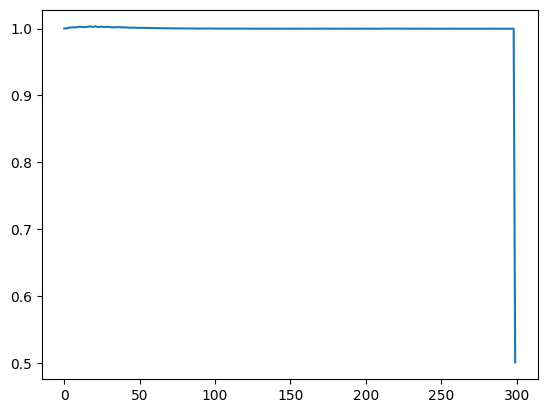

In [350]:
plt.plot(var)

In [254]:
points = jnp.array([[0.0, 0.0], [1.0, 0.0], [2.0, 0.0]])
neighbors = jnp.array([[0],[1]])
offsets = (1, 2, 3)
graph = gp.Graph(points=points, neighbors=neighbors, offsets=offsets)
covariance = gp.prepare_matern_covariance_discrete(p=1, cutoff=1, r_min=1e-4, r_max=10, n_bins=1000)

In [255]:
J = jax.jacfwd(Partial(gp.generate, graph, covariance, cuda=True))(jnp.zeros(len(points)))
cov = J @ J.T

In [256]:
cov

Array([[1.00001   , 0.4833636 , 0.23363805],
       [0.4833636 , 1.0000099 , 0.48336357],
       [0.23363805, 0.48336357, 1.0000099 ]], dtype=float32)

In [257]:
gp.covariance.compute_cov_matrix(covariance, points, points)

Array([[1.00001   , 0.48335734, 0.13973123],
       [0.48335734, 1.00001   , 0.48335734],
       [0.13973123, 0.48335734, 1.00001   ]], dtype=float32)

In [671]:
rng, k1 = jr.split(rng)
points = jr.normal(k1, (4, 2))
covariance = gp.prepare_matern_covariance_discrete(p=0, cutoff=1, r_min=1e-5, r_max=10, n_bins=1000)
cov = gp.covariance.compute_cov_matrix(covariance, points, points)

In [679]:
cov[2]

Array([0.13842683, 0.53596693, 1.00001   , 0.22170559], dtype=float32)

In [681]:
conditional_cov(cov, [1], keep_size=True)[2]

Array([0.09776274, 0.        , 0.71275234, 0.01048008], dtype=float32)

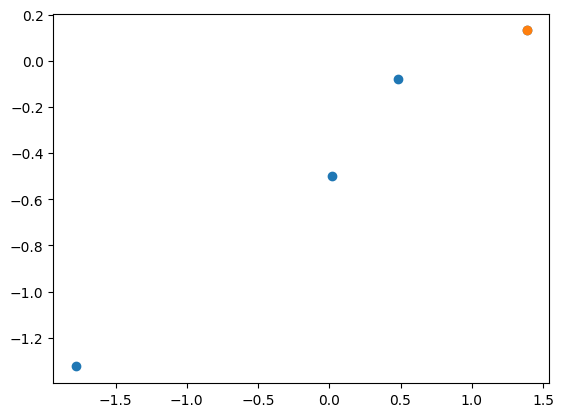

In [682]:
plt.scatter(*points.T)
plt.scatter(*points[3])

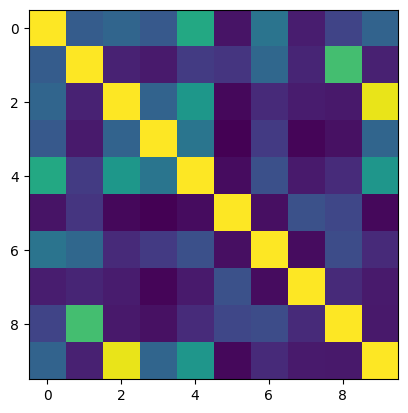

In [594]:
plt.imshow(cov)

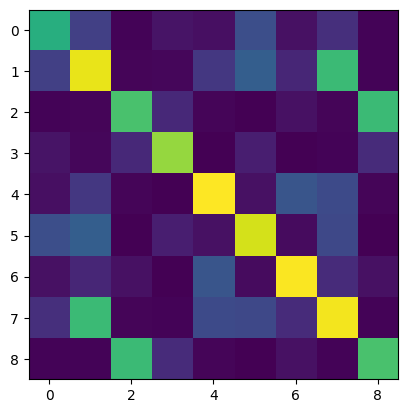

In [601]:
plt.imshow(conditional_cov(cov, jnp.array([4])))

5
4
6


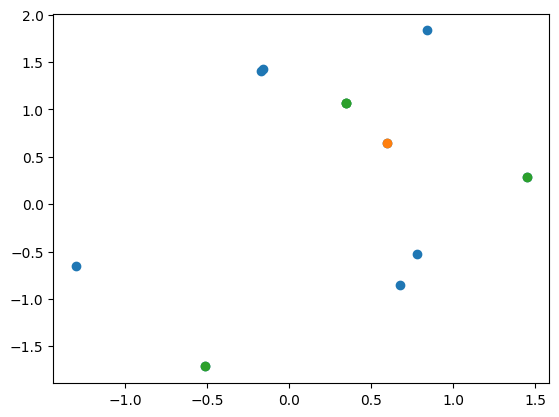

In [593]:
plt.scatter(*points.T)
plt.scatter(*points[0])

# Find most important single neighbors
neighbors = jnp.argsort(cov[0])[::-1][1:4]
# plt.scatter(*points[neighbors].T)

# Find most important neighbors iteratively
selected = jnp.array([neighbors[0]])
for i in range(3):
    cond_cov = conditional_cov(cov, jnp.array(selected))
    next_idx = jnp.argsort(cond_cov[0])[::-1][1]
    print(next_idx)
    selected = jnp.append(selected, next_idx)

plt.scatter(*points[selected].T)